<a href="https://colab.research.google.com/github/maggomor/Has-Paul-McCartney-died/blob/main/McCartney_Analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
#Load relevant packages that can never really hurt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

Welcome to this project where I want to analyze whether from available data on Beatles songs we can infere how much there is to the Paul-is-Dead-theory, i.e. that Paul McCartney died in a traffic accident early November, 1966. 
For this analysis, I have prepared a csv-Dataset using data on all songs on the regular Beatles-albums (sans Past Masters) via the "SpotifyR"-library in R. There exist alternatives for Python as well (e.g. Spotipy), but I have found the R-library to be more accessible and to give more options for retrieving song-characteristics, so I retrieved the data in R and here load them into Python. Pre-processing before that was negligible, all relevant analysis takes place here. Let's load in the dataset and get accustomed with it.

In [53]:
#generate a list of songs that were written by Sir Paul McCartney, aka Paul McCartney, aka Macca
macca = ['Love Me Do',
'P.S. I Love You',
'I Saw Her Standing There',
'Hold Me Tight',
'All My Loving',
'Can´t Buy Me Love',
'And I Love Her',
'Things We Said Today',
'Every Little Thing',
'What You´re Doing',
'Eight Days a Week',
'I´ll Follow the Sun',
'She´s A Woman',
'Another Girl',
'The Night Before',
'Tell Me What You See',
'I´m Down',
'I´ve Just Seen a Face',
'Paperback Writer',
'Yesterday',
'Drive My Car',
'I´m Looking Through You',
'Michelle',
'You Won´t See Me',
'Got To Get You Into My Life',
'Eleanor Rigby',
'For No One',
'Yellow Submarine',
'Good Day Sunshine',
'Here, There and Everywhere',
'Penny Lane',
'Hello, Goodbye',
'When I´m 64',
'Sgt. Pepper´s Lonely Hearts Club Band',
'Fixing a Hole',
'Lovely Rita',
'Getting Better',
'She´s Leaving Home',
'With a Little Help From My Friends',
'Sgt. Pepper´s Lonely Hearts Club Band (Reprise)',
'Magical Mystery Tour',
'Your Mother Should Know',
'The Fool on the HIll',
'Blackbird',
'Ob-La-Di, Ob-La-Da',
'Helter Skelter',
'Mother Nature´s Son',
'Rocky Raccoon',
'Wild Honey Pie',
'Back in the USSR',
'Lady Madonna',
'Hey Jude',
'I Will',
'Birthday',
'Honey Pie',
'Martha My Dear',
'Why Don´t We Do It in the Road?',
'All Together Now',
'Oh! Darling',
'You Never Give Me Your Money',
'Her Majesty',
'Golden Slumbers',
'Carry That Weight',
'Maxwell´s Silver Hammer',
'The End',
'She Came In Through The Bathroom Window',
'Get Back',
'Two of us',
'Let It Be',
'The Long and Winding Road']

#### Load the prepared dataset containing Beatles-Songs together with some song-measures
# Measures include: Mode (Major vs Minor), Duration_ms (Duration in Milliseconds), Danceability (How Dancy is a Song), Valence (How joyful is a song), Liveness (How lively is a song), Acousticness (How acoustic is a song), Instrumentalness (How instrumental is a song), Speechiness (How Speechy is a song)
df = pd.read_csv("https://raw.githubusercontent.com/maggomor/Has-Paul-McCartney-died/main/beatles.csv")

#Retrieve only pure track names (i.e. eliminate all "- Remaster 2018" things, etc.) 
df["track_name"] = df["track_name"].str.split(" - ").str[0]
#Create a column indicating whether a given track was written by Paul McCartney
#Note: This differs from the ascription of songwriting credits to "Lennon/McCartney"
df["macca"] = df["track_name"].isin(macca)

#Encode the so created column as a binary dummy
lc = LabelEncoder()
df["macca"] = lc.fit_transform(df["macca"])

#Drop duplicates that Spotify counts as differing songs but are actually the same
#This is important to not water down our results
df = df.drop_duplicates("track_name")

df.head()


,artist_name,track_name,album_name,mode,duration_ms,danceability,valence,tempo,speechiness,liveness,acousticness,instrumentalness,songlength,macca
0,The Beatles,I Saw Her Standing There,Please Please Me,1,173946,0.491,0.971,160.109,0.0361,0.0665,0.2700,0.00000,02:53,1
1,The Beatles,Mean Mr Mustard,Abbey Road,1,66533,0.676,0.970,100.687,0.0272,0.3510,0.0699,0.00002,01:06,0
2,The Beatles,"Ob-La-Di, Ob-La-Da",The Beatles,1,188813,0.803,0.969,113.193,0.0333,0.2220,0.1490,0.00471,03:08,1
3,The Beatles,Roll Over Beethoven,With The Beatles,1,165466,0.351,0.967,160.673,0.0628,0.0952,0.2890,0.00000,02:45,0
4,The Beatles,And Your Bird Can Sing,Revolver,1,120493,0.555,0.966,132.590,0.0282,0.2360,0.0067,0.04910,02:00,0


Above we can see some of the entries in this dataset. In particular, we get information on track- and album-name, mode (Major / Minor), duration, and spotify-internal track-statistics on danceability, valence (joyfulness), tempo, speechiness, liveness, acousticness, and instrumentalness of a song. We also have the actual songlength and we have added a Dummy-Variable encoding whether a given song was written by McCartney or not. Next, let's do some data preparation in order to get some nice visuals on Beatles-songs!

In [54]:
#Create a safety-copy of our dataset which we will pivot from wide- to long-format in a second
df2 = df.copy()
#create a dictionary relating old column names to a stub-name, and its inverse
temp_dict = {"ht1":"mode","ht2":"duration_ms","ht3":"danceability", "ht4":"valence", "ht5":"tempo", "ht6":"speechiness", "ht7":"liveness", "ht8":"acousticness", "ht9":"instrumentalness"}
inv_dict = {v: k for k, v in temp_dict.items()}

#get columns we are interested in, i.e. pop out unimportant ones
columns = df.columns.tolist()
columns.pop(0)
columns.pop(0)
columns.pop(0)

#prepare Dataframe so that we rename the relevant columns we want to plot to stubnames
df2 = df2.rename(inv_dict, axis=1)

#Create a long-format dataset
df2 = pd.wide_to_long(df2, stubnames='ht', i=['artist_name', 'track_name', "album_name"], j='type')
df2 = df2.reset_index()

#Create a dictionary that turns our stub-entries into meaningful categories again
temp_dict2 = {1:"mode",2:"duration_ms",3:"Dancy", 4:"Joy", 5:"tempo", 6:"speechiness", 7:"Live", 8:"Acoust", 9:"Instr"}

#Rename the entries in "type" to make sense to us
df2["type"] = df2["type"].replace(temp_dict2)

#Create a new dataframe for graphing that contains only the categories we are interested in:
#Dancy-ness, Joy, Liveliness, Acousticness, and Instrumentalness
df3 = df2[df2["type"]!="tempo"]
df3 = df3[df3["type"]!="duration_ms"]
df3 = df3[df3["type"]!="mode"]
df3 = df3[df3["type"]!="speechiness"]

Now we have prepared this dataset, let's get some nice plots!
Plot the measures of interest as violinplots.
Values range from 0 to 1 and violin-plots are split in half.
The left, blue half shows values for songs not written by McCartney, the right, orange half shows values for songs written by McCartney.

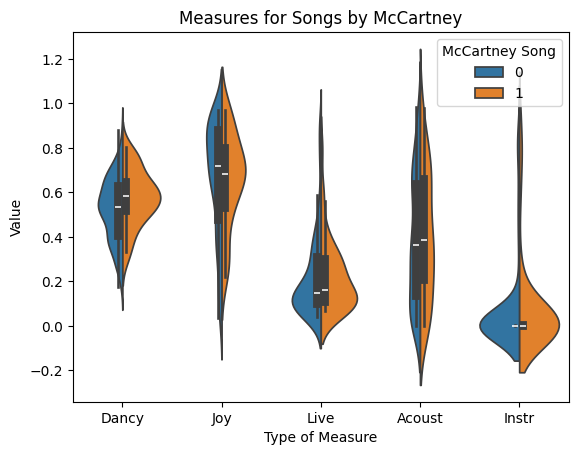

In [55]:
plt.figure()
ax=sns.violinplot(data=df3, x="type",y="ht",hue="macca", split=True)
ax.legend(title='McCartney Song', loc='upper right')
ax.set(xlabel="Type of Measure",ylabel="Value",title="Measures for Songs by McCartney")
plt.show()

We see that Songs written by other Beatles and by Paul McCartney differ in subtle details. This is not surprising as we know that Lennon, McCartney, and Harrison all had quite different styles

In [56]:

#Prepare Data Analysis for the supposed timeframe in which Paul McCartney had allegedly been dead

#Create a new dataframe as copy of the old one
df4 = df3.copy()

#### Theory "Paul is dead" claims Paul died on November 9th, 1966. Sgt. Peppers Recording started November 24th 1966. Hence, all before Sgt. Pepper gets a 0, everything after a 1
dead_paul_albums = ["Sgt. Pepper's Lonely Hearts Club Band ", "Magical Mystery Tour ", "The Beatles", "Abbey Road ", "Let It Be ", "Yellow Submarine "]
#Create a dummy-column indicating whether a song falls in the period where McCartney was allegedly dead or not
df4["Dead_Paul"] = df4["album_name"].isin(dead_paul_albums)
paul_lc = LabelEncoder()
df4["Dead_Paul"] = paul_lc.fit_transform(df4["Dead_Paul"])
#For plot-creation, get two new dataframes representing songs written by McCartney and those written by others
df5 = df4[df4["macca"]==1]
df6 = df4[df4["macca"]==0]

Let's see if we can see some differences in general Beatles-songs before and after the alleged death of Paul McCartney.
Plot the measures of interest as violinplots.
Values range from 0 to 1 and violin-plots are split in half.
The left, blue half shows values for songs written before the alleged death, the right, orange half shows values for songs written afterwards.

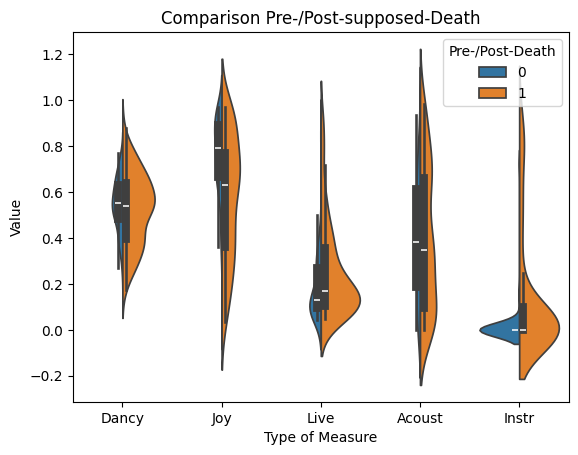

In [57]:
plt.figure()  
ax = sns.violinplot(data=df4, x="type",y="ht",hue="Dead_Paul", split=True)    
ax.legend(title='Pre-/Post-Death', loc='upper right')
ax.set(xlabel="Type of Measure",ylabel="Value",title="Comparison Pre-/Post-supposed-Death")
plt.show()

We do see some differences. Note how apparently Beatles-songs used to be so much more joyous before the alleged death of Paul. Is this evidence that everyone was sad afterwards due to Paulie dying? How are these differences to be explained? Is it the case only for McCartney-songs? Or for all? Let's see!
Plot the measures of interest as violinplots.
Values range from 0 to 1 and violin-plots are split in half.
All songs here were written by Paul McCartney (or allegedly so, if the hypothesis is true).
The left, blue half shows values for songs written before the alleged death, the right, orange half shows values for songs written afterwards.

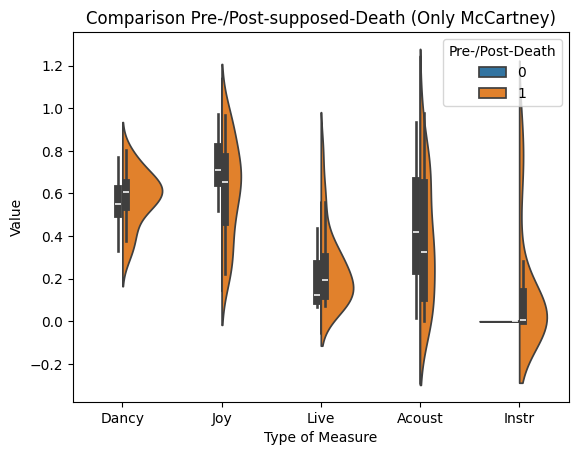

In [58]:
plt.figure()  
ax=sns.violinplot(data=df5, x="type",y="ht",hue="Dead_Paul", split=True)
ax.legend(title='Pre-/Post-Death', loc='upper right')
ax.set(xlabel="Type of Measure",ylabel="Value", title="Comparison Pre-/Post-supposed-Death (Only McCartney)")
plt.show()

Odd: we do see some differences! But maybe they are due to there being some general shifts in songwriting? After all, the 1960s were a musically inventive period. It was not unheard of for artists to radically change styles from early to late 60s. Think of Bob Dylan!

Then let's compare how Beatles-songs changed for songs written by other Beatles.
Plot the measures of interest as violinplots.
Values range from 0 to 1 and violin-plots are split in half.
All songs here were written by other Beatles-members.
The left, blue half shows values for songs written before the alleged death, the right, orange half shows values for songs written afterwards

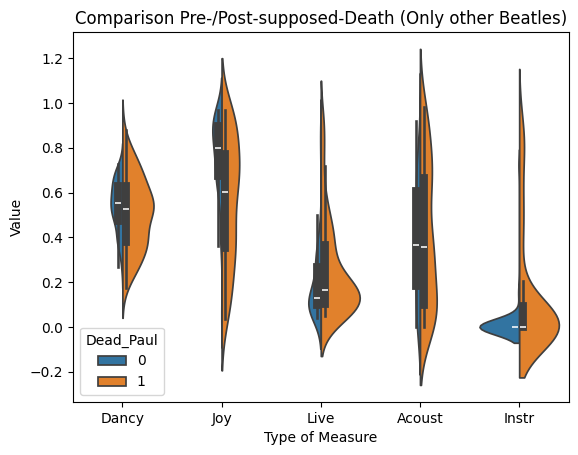

In [59]:
plt.figure()
ax=sns.violinplot(data=df6, x="type",y="ht",hue="Dead_Paul", split=True)
ax.set(xlabel="Type of Measure",ylabel="Value", title="Comparison Pre-/Post-supposed-Death (Only other Beatles)")
plt.show()
###################################################################################

We see: also songs by other Beatles are somewhat different pre-/post Sgt. Pepper. This is hardly a surprise.

We have seen some graphical evidence that there are indeed some changes in Beatles' song-characteristics before and after the alleged death of Sir Paul McCartney. Is this evidence?
The null-hypothesis is that Paul McCartney's songs did *not* change in a significantly different way from other Beatles-compositions. A fitting framework for answering such a question is a Difference-in-Differences-analysis. Empirically, we can implement this by a regular Least-Squares-Regression with two dummy-variables ("Written by McCartney" and "Pre-/Post-Death") as well as their interaction-term.
Let's create this dataset

In [60]:
df["Dead_Paul"] = df["album_name"].isin(dead_paul_albums)
df["Dead_Paul"] = paul_lc.fit_transform(df["Dead_Paul"])
df["DiD"] = df["macca"]*df["Dead_Paul"]
#The coefficient on this last variable, "DiD", will later capture the Difference-in-Differences-coefficient that informs us
#whether there is a significantly different change in McCartney's song-characteristics pre-/post-alleged death

#For empirical analysis, let's use the Statsmodels-package, since the summary-output is nicely interpretable there
import statsmodels.api as sm

#Create an iterable list of relevant Dependent Variables:
#Song Mode, Duration, Danceability, Valence (Joyfulness), Tempo, Speechiness, Liveness, Acousticness, Instrumentalness
columns = df.columns.tolist()
columns.pop(0)
columns.pop(0)
columns.pop(0)
columns.pop(9)
columns.pop(9)
columns.pop(9)
columns.pop(9)

#Create a Regressor-Matrix containing a constant and the two indicator-variables as well as the Interaction-term
x = df[["macca","Dead_Paul","DiD"]]
x = sm.add_constant(x)

#Run Regressions regressing any of the named categories on our predictors
for i in columns:
    y = df[i]
    model = sm.OLS(y, x).fit()
    print("Regular Diff-in-Diff Results")
    print("Dependent Variable is "+str(i))
    print("-------------------------------------------")
    print(model.summary())
    print("-------------------------------------------")
    print("-------------------------------------------")

Regular Diff-in-Diff Results
Dependent Variable is mode
-------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                   mode   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.835
Date:                Fri, 23 May 2025   Prob (F-statistic):              0.142
Time:                        10:04:36   Log-Likelihood:                -98.698
No. Observations:                 208   AIC:                             205.4
Df Residuals:                     204   BIC:                             218.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

The Interaction-term is significant only for "Mode", otherwise not - interpreted as a Linear-Probability-Model, this means that the difference in likelihood of writing a positive major-key song for McCartney and other Beatles increased by 29%-points. Not completely impossible given how Lennon deteriorated and George always was somewhat melancholic - and no one let Ringo write songs anyway.
To summarize these results: the coefficient on "DiD", which captures the differential effect of how Paul McCartney changed pre-/post the alleged death versus how the other Beatles changed. Remember: if Paul really did die, we would expect his songwriting to change - and change in a different way compared to how other Beatles' songs changed. Apart from Grampa McCartney's songs about being old and jolly being more often in major than Lennon's heroin-dreams, we do not find any evidence for that - hence, there is very little evidence supporting the Paul-is-Dead-claim.
But hang on, perhaps we have ignored some other effects?
By not controlling for some time-era characteristics, perhaps there were also some general trends during the makings of these different albums that influenced the songwriting? Surely writing a song in the summer of love must have been different than writing one in 1963!
Let's try and control this away with a Fixed-Effects-regression. We allow there to be a common influence to every album by creating Dummy-Variables for these.
Technically, a within-transformation is more efficient, but here this makes little difference to us, so we choose to create dummies.

In [61]:
albums = df["album_name"].unique().tolist()
#Create a new dataframe for safekeeping all previous results
df10 = df.copy()

#One-Hot-Encode Beatles-albums
one_hot = pd.get_dummies(df10['album_name'])
df10 = df10.drop('album_name',axis = 1)
df10 = df10.join(one_hot)

#Create a matrix of fixed-effects-regressors
#We need to pay attention multicollinearity
#We have to drop the constant and the "Dead_Paul"-dummy because they would be perfectly collinear with the sum of 
#columns of the post-alleged-death-album-dummies
FEx = df10[albums+["macca","DiD"]].astype(int)


#Run again regular OLS-Regressions as well as Regressions-including Fixed-Effects side-by-side to see if anything changes
for i in columns:
    y = df[i]
    model = sm.OLS(y, x).fit()
    print("Regular Diff-in-Diff Results")
    print("Dependent Variable is "+str(i))
    print("-------------------------------------------")
    print(model.summary())
    print("-------------------------------------------")
    model = sm.OLS(y, FEx).fit()
    print("FIXED EFFECTS Diff-in-Diff RESULTS")
    print("Dependent Variable is "+str(i))
    print("-------------------------------------------")
    print(model.summary())
    print("-------------------------------------------")
    print("-------------------------------------------")

Regular Diff-in-Diff Results
Dependent Variable is mode
-------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                   mode   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.835
Date:                Fri, 23 May 2025   Prob (F-statistic):              0.142
Time:                        10:04:36   Log-Likelihood:                -98.698
No. Observations:                 208   AIC:                             205.4
Df Residuals:                     204   BIC:                             218.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Interestingly, this does not make much of a difference!
Still, no DiD-coefficient is significant except for the one on "Mode", and that one can perhaps easily be explained by Lennon getting mopey.
But hang on, we have so far made inference based on homoskedastic standard errors. In presence of heteroskedasticity (likely to be the case), our inference on statistical significance is invalid! The coefficients might be correct, but any statistical inference is not. Let's correct for that by specifying heteroskedasticity-robustness!

In [62]:
for i in columns:
    y = df[i]
    model = sm.OLS(y, x).fit(cov_type="HC3")
    print("Regular Diff-in-Diff Results")
    print("Dependent Variable is "+str(i))
    print("-------------------------------------------")
    print(model.summary())
    print("-------------------------------------------")
    model = sm.OLS(y, FEx).fit(cov_type="HC3")
    print("FIXED EFFECTS Diff-in-Diff RESULTS")
    print("Dependent Variable is "+str(i))
    print("-------------------------------------------")
    print(model.summary())
    print("-------------------------------------------")
    print("-------------------------------------------")

Regular Diff-in-Diff Results
Dependent Variable is mode
-------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                   mode   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.707
Date:                Fri, 23 May 2025   Prob (F-statistic):              0.167
Time:                        10:04:36   Log-Likelihood:                -98.698
No. Observations:                 208   AIC:                             205.4
Df Residuals:                     204   BIC:                             218.7
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

No, our results remain fairly identical to before - and still, the coefficient on "Mode" remains significant!
Is that then evidence for the Paul-is-dead-hypothesis? Have we found an indicator that McCartney's songs pre- and post-death differ in a significantly different manner than for other Beatles?
No, not really. We have shown that Paul's increase in writing happy songs is higher than the increase in writing happy songs by other Beatles. That is no evidence that Paul died, that is evidence that Paul got happier (or learned how to pander more to his audience).
In conclusion, with this Difference-in-Difference analysis we can confidently say that there is no conclusive evidence supporting the Paul-is-dead-Hypothesis.
Does this fully hold? Not necessarily. There might be endogeneity concerns interfereing with our analysis. For example, if Paul really did die and whoever replaced him in songwriting just masterfully copied a Paul-Mc-Cartney-style, we would not be able to detect it here. For that, other techniques would have to be employed, such as an Instrumental-Variables-analysis or others...
But that is for another time :-)